<a href="https://colab.research.google.com/github/DmitryKutsev/DeepHW/blob/master/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2020-10-19 13:34:44--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  16.7MB/s    in 40s     

2020-10-19 13:35:25 (16.2 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [2]:
!wget https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py

--2020-10-19 13:35:25--  https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10563 (10K) [text/plain]
Saving to: ‘data.py’

data.py             100%[===================>]  10.32K  --.-KB/s    in 0s      

2020-10-19 13:35:26 (91.9 MB/s) - ‘data.py’ saved [10563/10563]



In [3]:
!mv data.py mydata.py

In [25]:
from tqdm import trange
import math
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
import zipfile
from torch import nn
import seaborn as sns
from mydata import Downloader, Parser
import matplotlib.pyplot as plt

In [5]:
torch.__version__

'1.6.0+cu101'

### **DATA**


In [6]:
data_path = './mydata/'

In [7]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
train = pd.read_csv('/content/drive/My Drive/dialogs_train.csv') 
valid = pd.read_csv('/content/drive/My Drive//dialogs_valid.csv') 

In [9]:
unique_categories = set(train.category.unique().tolist() + valid.category.unique().tolist())

category2index = {category: index for index, category in enumerate(unique_categories)}

In [10]:
train['target'] = train.category.map(category2index)
valid['target'] = valid.category.map(category2index)

In [11]:
valid['target'][:3]

0    5
1    4
2    5
Name: target, dtype: int64

In [12]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, vocab, pad_index=0, max_length=32):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        
        self.pad_index = pad_index
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def tokenization(self, text):
        
        tokens = wordpunct_tokenize(text)
        
        token_indices = [self.vocab[tok] for tok in tokens if tok in self.vocab]
        
        return token_indices
    
    def padding(self, tokenized_text):
        
        tokenized_text = tokenized_text[:self.max_length]
        
        tokenized_text += [self.pad_index] * (self.max_length - len(tokenized_text))
        
        return tokenized_text
    
    def __getitem__(self, index):
        
        text = self.texts[index]        
        target = self.targets[index]
        
        tokenized_text = self.tokenization(text)
        tokenized_text = self.padding(tokenized_text)
        
        tokenized_text = torch.tensor(tokenized_text)
        
        return tokenized_text, target

In [13]:
train_x = list(train.question)
train_y = list(train.target)

valid_x = list(valid.question)
valid_y = list(valid.target)

### **Embeddings**

In [14]:
def load_embeddings(zip_path, filename, pad_token='PAD', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with zipfile.ZipFile(zip_path) as zipped_file:
        with zipped_file.open(filename) as file_object:

            vocab_size, embedding_dim = file_object.readline().decode('utf-8').strip().split()

            vocab_size = int(vocab_size)
            embedding_dim = int(embedding_dim)
            
            max_words = vocab_size if max_words <= 0 else max_words
            
            vocab[pad_token] = len(vocab)
            embeddings.append(np.zeros(embedding_dim))

            progress_bar = tqdm(total=max_words, disable=not verbose)

            for line in file_object:
                parts = line.decode('utf-8').strip().split()

                token = ' '.join(parts[:-embedding_dim]).lower()
                
                if token in vocab:
                    continue
                
                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                vocab[token] = len(vocab)
                embeddings.append(word_vector)

                progress_bar.update()
                
                if len(vocab) == max_words:
                    break

            progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [15]:
vocab, embeddings = load_embeddings('./wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec', max_words=100_000)

100%|█████████▉| 99999/100000 [00:12<00:00, 7776.38it/s]


In [16]:
index2token = {index: token for token, index in vocab.items()}

In [17]:
emb_norms = np.linalg.norm(embeddings, axis=1)

In [18]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
x, y = train_dataset[0]

In [19]:
embeddings = torch.tensor(embeddings).float()
embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
x_embed = embedding_layer(x)

In [20]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
valid_dataset = TextClassificationDataset(texts=valid_x, targets=valid_y, vocab=vocab)

train_loader = DataLoader(train_dataset, batch_size=128)
valid_loader = DataLoader(valid_dataset, batch_size=128)

In [21]:
for x, y in train_loader:
  print(x.size())
  print(y.size())
  break

torch.Size([128, 32])
torch.Size([128])


In [130]:
valid_x[0]

'can i activate this phone with boost mobile'

In [132]:
  for x, y in valid_loader:
    print(x)
    print(y)
    
    y_pred = model.forward(x)
    loss = criterion(y_pred, y)
    break

tensor([[   82,    28, 15122,  ...,     0,     0,     0],
        [   28,    36,     8,  ...,    57,     1,    28],
        [   82,     2,  4236,  ...,     0,     0,     0],
        ...,
        [   74,    41,  1101,  ...,     0,     0,     0],
        [  218,    20,   264,  ...,     0,     0,     0],
        [   14,    20,  5822,  ...,     0,     0,     0]])
tensor([5, 4, 5, 1, 4, 4, 6, 3, 0, 4, 0, 3, 5, 6, 3, 5, 6, 4, 3, 1, 5, 0, 5, 3,
        1, 0, 4, 7, 7, 5, 6, 5, 5, 2, 4, 2, 4, 6, 7, 5, 5, 4, 5, 6, 0, 4, 6, 5,
        6, 4, 3, 1, 6, 6, 0, 1, 0, 0, 4, 1, 5, 2, 5, 6, 6, 2, 4, 3, 6, 0, 2, 6,
        6, 6, 5, 1, 6, 4, 6, 4, 5, 6, 5, 5, 5, 6, 0, 6, 4, 3, 6, 5, 3, 7, 3, 4,
        6, 3, 6, 4, 4, 4, 0, 5, 6, 5, 4, 2, 4, 3, 1, 2, 6, 4, 7, 6, 5, 4, 0, 0,
        2, 5, 6, 6, 4, 0, 4, 4])


### **AVERAGE MODEL**

In [158]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, embeddings, linear_1_size, linear_2_size, n_classes):
        super().__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        
        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
        
        self.linear_1 = nn.Linear(in_features=embeddings.shape[-1], out_features=linear_1_size)
        self.linear_2 = nn.Linear(in_features=linear_1_size, out_features=linear_2_size)
        self.linear_3 = nn.Linear(in_features=linear_2_size, out_features=n_classes)
        
    def forward(self, x):
        

        x = self.embedding_layer(x)
        x = x.sum(dim=1)
        x = self.batch_norm(x)
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.linear_2(x)
        x = torch.relu(x)
        
        x = self.linear_3(x)
        
        x = torch.softmax(x, dim=-1)
        
        
        return x

In [159]:

model = DeepAverageNetwork(embeddings=embeddings,
                           linear_1_size=256, 
                           linear_2_size=128, 
                           n_classes=len(category2index))

In [160]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)


In [141]:
train_losses = []
train_acc = 0

In [142]:

for x, y in train_loader:
  progress_bar = tqdm(total=len(train_loader))
  y_pred = model.forward(x)
  loss = criterion(y_pred, y)
  train_acc += (y_pred.argmax(1) == cls).sum().item()
  

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  progress_bar.update()
  losses.append(loss)
scheduler.step()
print(f"epoch {i}, train loss {loss}")
progress_bar.close()

for x, y in valid_loader:        
    with torch.no_grad():
        
        x_forw = model.forward(x)
        y_pred = torch.softmax(x_forw, dim=-1)
        optimizer.zero_grad()
        # print(y_pred.argmax(1))
        # print(y)
        acc = (y_pred.argmax(1) == y).sum().item()
        acc_list.append(acc)
        optimizer.step()
        losses.append(loss)
        optimizer.zero_grad()
        optimizer.step()
        losses.append(loss)
        break
print(f"test loss {loss}")
break









  0%|          | 0/1954 [00:00<?, ?it/s]

NameError: ignored

In [139]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:

epochs = 2
train_losses = []
test_losses = []
train_acc = 0

for epoch in range(epochs):
  counter = 0
  for x, y in train_loader:

    y_pred = model.forward(x)
    train_loss = criterion(y_pred, y)
    train_acc += (y_pred.argmax(1) == y).sum().item()
    

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    progress_bar.update()
    losses.append(loss)
    counter +=1

    if counter%500 == 0:
      print(f"epoch {epoch} train loss {train_loss }")
  scheduler.step()

  for x, y in valid_loader:        
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          optimizer.zero_grad()
          # print(y_pred.argmax(1))
          # print(y)
          test_loss = criterion(y_pred, y)
          test_acc = (y_pred.argmax(1) == y).sum().item()
          acc_list.append(test_acc)
          optimizer.step()
          test_losses.append(test_loss)
          optimizer.zero_grad()
          optimizer.step()
          test_losses.append(loss)
          counter +=1

          # if counter%500 == 0:
            # print(f"epoch {epoch} test loss {loss}, train loss {loss}")
  print(f"epoch {epoch} test loss {test_loss}, train loss {train_loss}")



NameError: ignored

In [ ]:
    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), np.mean(test_losses)))
    
    test_preds = np.concatenate(test_preds)
    # Применяем сигмоиду
    test_preds = sigmoid(test_preds.squeeze())
    test_targets = np.concatenate(test_targets).squeeze()
    
    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0
    
    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))
        
    if np.mean(test_losses) < best_test_loss:
        best_test_loss = np.mean(test_losses)
    else:
        print('Early stopping')
        break

In [68]:
def test():
  test_losses = list()
  preds = list()
  test_acc_list = list()

  # заметьте, что мы поменяли наш лоадер на валидационный
  #losses = []

  for i in trange(epochs):
    count = 0
    for x, y in valid_loader:
        
        with torch.no_grad():
            
            x_forw = model.forward(x)
            y_pred = torch.softmax(x_forw, dim=-1)
            optimizer.zero_grad()
            # print(y_pred.argmax(1))
            # print(y)
            acc = (y_pred.argmax(1) == y).sum().item()
            acc_list.append(acc)
            optimizer.step()
            losses.append(loss)
            optimizer.zero_grad()
            optimizer.step()
            losses.append(loss)
            break
    print(f"test loss {loss}")

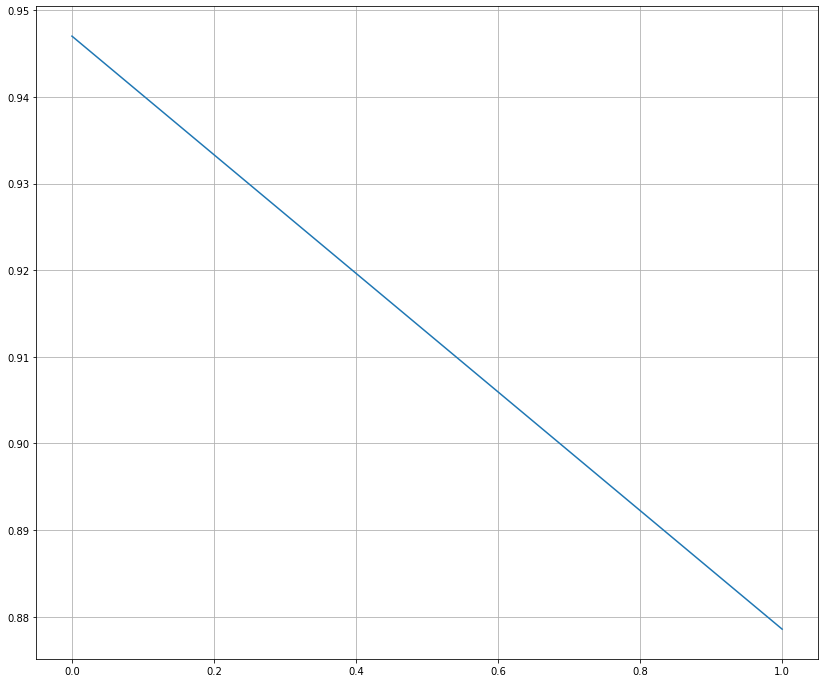

In [69]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), losses)
plt.grid()

In [96]:
from torch.nn import Sigmoid
sigmoid = Sigmoid()
from sklearn.metrics import accuracy_score

In [137]:

def test():
  losses = list()
  preds = list()
  acc_list = list()

  # заметьте, что мы поменяли наш лоадер на валидационный
  #losses = []

  for i in trange(epochs):
    count = 0
    for x, y in valid_loader:
        
        with torch.no_grad():
            
            x_forw = model.forward(x)
            y_pred = torch.softmax(x_forw, dim=-1)
            optimizer.zero_grad()
            # print(y_pred.argmax(1))
            # print(y)
            acc = (y_pred.argmax(1) == y).sum().item()
            acc_list.append(acc)
            optimizer.step()
            losses.append(loss)
            optimizer.zero_grad()
            optimizer.step()
            losses.append(loss)
            break
    print(f"epoch {i}, loss {loss}")
    








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 72.16it/s]

82
epoch 0, loss 1.0179855823516846
82
epoch 1, loss 1.0179855823516846
82
epoch 2, loss 1.0179855823516846
82
epoch 3, loss 1.0179855823516846
82
epoch 4, loss 1.0179855823516846
82
epoch 5, loss 1.0179855823516846
82
epoch 6, loss 1.0179855823516846
82
epoch 7, loss 1.0179855823516846
82
epoch 8, loss 1.0179855823516846
82
epoch 9, loss 1.0179855823516846


In [125]:
for x, y in valid_loader:
  print(x)
  print(y)
  break

tensor([[   82,    28, 15122,  ...,     0,     0,     0],
        [   28,    36,     8,  ...,    57,     1,    28],
        [   82,     2,  4236,  ...,     0,     0,     0],
        ...,
        [   74,    41,  1101,  ...,     0,     0,     0],
        [  218,    20,   264,  ...,     0,     0,     0],
        [   14,    20,  5822,  ...,     0,     0,     0]])
tensor([5, 4, 5, 1, 4, 4, 6, 3, 0, 4, 0, 3, 5, 6, 3, 5, 6, 4, 3, 1, 5, 0, 5, 3,
        1, 0, 4, 7, 7, 5, 6, 5, 5, 2, 4, 2, 4, 6, 7, 5, 5, 4, 5, 6, 0, 4, 6, 5,
        6, 4, 3, 1, 6, 6, 0, 1, 0, 0, 4, 1, 5, 2, 5, 6, 6, 2, 4, 3, 6, 0, 2, 6,
        6, 6, 5, 1, 6, 4, 6, 4, 5, 6, 5, 5, 5, 6, 0, 6, 4, 3, 6, 5, 3, 7, 3, 4,
        6, 3, 6, 4, 4, 4, 0, 5, 6, 5, 4, 2, 4, 3, 1, 2, 6, 4, 7, 6, 5, 4, 0, 0,
        2, 5, 6, 6, 4, 0, 4, 4])


### **CNN**

In [44]:
class MyCNN(nn.Module):

  def __init__(self, embeddings, c1_in, c2_in, c2_out, l1_out, l2_out, n_classes):

    super().__init__()

    self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
    self.conv1 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2, stride=1, padding=1)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
    self.dropout = nn.Dropout(p=0.5)
    
    self.linear_1 = nn.Linear(in_features=101, out_features=32)
    self.linear_2 = nn.Linear(in_features=32, out_features=16)
    self.linear_3 = nn.Linear(in_features=16, out_features=n_classes)


  def forward(self, x):
    residual = x
    x = self.embedding_layer(x)
    x = self.conv1(x)
    x = torch.max_pool1d(x, kernel_size=3)
    x = self.relu(x)
    x = self.conv2(x)
    x = x.sum(dim=1)
    x = self.linear_1(x)
    x = torch.relu(x)
    x += residual
    x = self.linear_2(x)  
    x = self.dropout(x)
    x = torch.relu(x)   
    x = self.linear_3(x)
 

    return x


In [45]:
model = MyCNN(embeddings=embeddings,
                          c1_in=32, 
                          c2_in=64, 
                          c2_out=101,
                          l1_out=32, 
                          l2_out=16,
                           n_classes=len(category2index))


In [46]:
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.CUDA()

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

epochs = 6
losses = []
for i in trange(epochs):
  for x, y in train_loader:
    if CUDA:
      x = x.CUDA()
      y = y.CUDA()

    y_pred = model.forward(x)
    loss = criterion(y_pred, y)
    
     

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss)
  print(f"epoch {i}, loss {loss}")

 17%|█▋        | 1/6 [02:33<12:48, 153.66s/it]

epoch 0, loss 58.409385681152344


 33%|███▎      | 2/6 [04:57<10:03, 150.86s/it]

epoch 1, loss 2.057128667831421


 50%|█████     | 3/6 [07:21<07:26, 148.77s/it]

epoch 2, loss 2.065150260925293


 67%|██████▋   | 4/6 [09:45<04:54, 147.29s/it]

epoch 3, loss 2.0877952575683594
epoch 4, loss 2.1173624992370605


100%|██████████| 6/6 [14:31<00:00, 145.29s/it]

epoch 5, loss 2.147245407104492


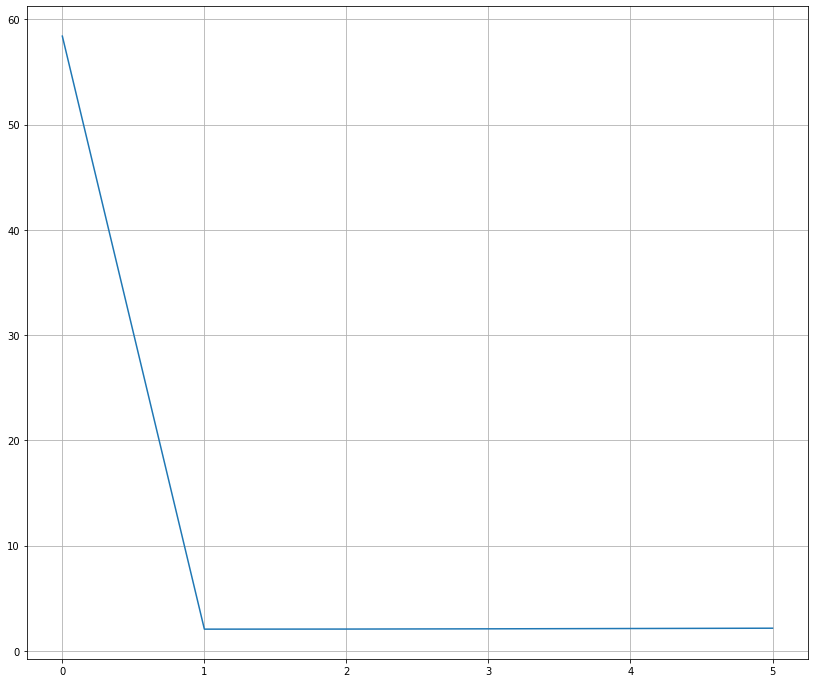

In [48]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), losses)
plt.grid()

In [49]:
losses = list()
preds = list()
acc_list = list()

# заметьте, что мы поменяли наш лоадер на валидационный
losses = []

for i in range(epochs):
  count = 0
  for x, y in valid_loader:
      
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          optimizer.zero_grad()

          optimizer.step()
          losses.append(loss)
          optimizer.zero_grad()
          optimizer.step()
          losses.append(loss)
  print(f"epoch {i}, loss {loss}")

 17%|█▋        | 1/6 [00:15<01:18, 15.65s/it]

epoch 0, loss 2.147245407104492


 33%|███▎      | 2/6 [00:31<01:02, 15.63s/it]

epoch 1, loss 2.147245407104492


 50%|█████     | 3/6 [00:46<00:46, 15.57s/it]

epoch 2, loss 2.147245407104492


 67%|██████▋   | 4/6 [01:02<00:31, 15.57s/it]

epoch 3, loss 2.147245407104492


 83%|████████▎ | 5/6 [01:17<00:15, 15.57s/it]

epoch 4, loss 2.147245407104492


100%|██████████| 6/6 [01:33<00:00, 15.56s/it]

epoch 5, loss 2.147245407104492


In [50]:
# out1 = cnn1(inp)
# out2 = cnn2(inp)
# full_out = torch.cat([out1, ou2], dim=1) # dim=1 is the channel dimension for 2D images
# full_out = full_out.view(full_out.size(0), -1) # Linearize for the FC

### **PARALLEL CNN**

In [51]:
class MyParallelCNN(nn.Module):
# c1_in=32, c2_in=64, c2_out=101, l1_out=16384, l2_out=64
  def __init__(self, embeddings, c1_in, c2_in, c2_out, l1_out, l2_out, n_classes):

    super().__init__()

    self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
    self.conv1 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1)

    self.relu = nn.ReLU()
    self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=2, stride=1, padding=1)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
    self.dropout = nn.Dropout(p=0.5)
    
    self.linear_1 = nn.Linear(in_features=101, out_features=32)
    self.linear_2 = nn.Linear(in_features=32, out_features=16)
    self.linear_3 = nn.Linear(in_features=16, out_features=n_classes)


  def forward(self, x):

    x = self.embedding_layer(x)
    x1 = self.conv1(x)
    x1 = torch.max_pool1d(x1,padding=1, kernel_size=3)
    x2 = self.conv2(x)
    x2 = torch.avg_pool1d(x2, padding=1, kernel_size=3)
    x = torch.cat([x1, x2], dim=1)
    x = self.relu(x)
    x = self.linear_1(x)
    x = x.sum(dim=1)
    x = torch.relu(x)
    x = self.linear_2(x)
    x = self.dropout(x)
    x = torch.relu(x)
    x = self.linear_3(x)
 

    return x

In [52]:
model = MyParallelCNN(embeddings=embeddings,
                          c1_in=32, 
                          c2_in=64, 
                          c2_out=101,
                          l1_out=32, 
                          l2_out=16,
                           n_classes=len(category2index))

In [53]:
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.CUDA()

In [54]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

epochs = 6
losses = []
for i in  trange(epochs):
  for x, y in train_loader:
    if CUDA:
      x = x.CUDA()
      y = y.CUDA()

    y_pred = model.forward(x)
    loss = criterion(y_pred, y)
    
     

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss)
  print(f"epoch {i}, loss {loss}")

 17%|█▋        | 1/6 [03:18<16:31, 198.40s/it]

epoch 0, loss 2.0787596702575684


 33%|███▎      | 2/6 [06:37<13:14, 198.59s/it]

epoch 1, loss 1.937432050704956


 50%|█████     | 3/6 [09:55<09:54, 198.32s/it]

epoch 2, loss 1.8413945436477661


 67%|██████▋   | 4/6 [13:12<06:35, 197.95s/it]

epoch 3, loss 1.8236525058746338


 83%|████████▎ | 5/6 [16:29<03:17, 197.79s/it]

epoch 4, loss 1.8599425554275513


100%|██████████| 6/6 [19:47<00:00, 197.83s/it]

epoch 5, loss 1.7188743352890015


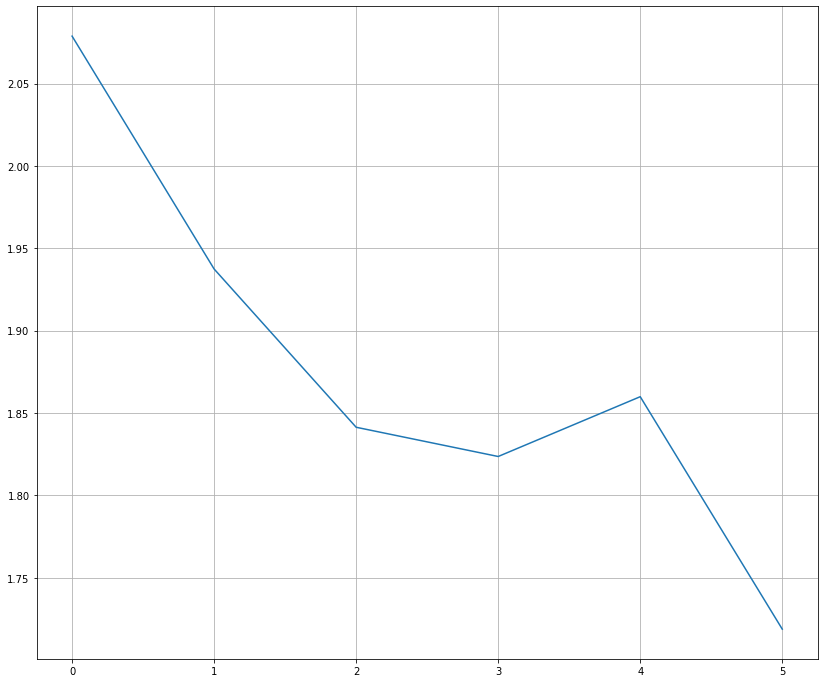

In [56]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), losses)
plt.grid()

In [57]:
losses = list()
preds = list()
acc_list = list()

# заметьте, что мы поменяли наш лоадер на валидационный
losses = []

for i in trange(epochs):
  count = 0
  for x, y in valid_loader:
      
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          optimizer.zero_grad()

          optimizer.step()
          losses.append(loss)
          optimizer.zero_grad()
          optimizer.step()
          losses.append(loss)
  print(f"epoch {i}, loss {loss}")

 17%|█▋        | 1/6 [00:20<01:43, 20.68s/it]

epoch 0, loss 1.7188743352890015


 33%|███▎      | 2/6 [00:41<01:22, 20.67s/it]

epoch 1, loss 1.7188743352890015


 50%|█████     | 3/6 [01:02<01:02, 20.68s/it]

epoch 2, loss 1.7188743352890015


 67%|██████▋   | 4/6 [01:22<00:41, 20.64s/it]

epoch 3, loss 1.7188743352890015


 83%|████████▎ | 5/6 [01:43<00:20, 20.62s/it]

epoch 4, loss 1.7188743352890015


100%|██████████| 6/6 [02:03<00:00, 20.61s/it]

epoch 5, loss 1.7188743352890015


### **LSTM**

In [58]:
# vocab
class LSTM(nn.Module):
    
    def __init__(self, embeddings, hidden_size, linear_1_size, linear_2_size, n_classes):
        super().__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        
        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])

        self.lstm = nn.LSTM(input_size=300, hidden_size=128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
        # self.hidden = (torch.zeros(1, 1,hidden_size), torch.zeros(1,1,hidden_size))
        
        self.linear_1 = nn.Linear(in_features=256, out_features=32)

        self.linear_2 = nn.Linear(in_features=32, out_features=16)
        self.linear_3 = nn.Linear(in_features=16, out_features=128)
        
    def forward(self, x):
        #print(x.size())
        x = self.embedding_layer(x)
        #print(x.size())

        #print(x.size())

        # x = self.lstm(view(len(seq), 1, -1), self.hidden)
        #print(x.size())
        # x = x.sum(dim=1)
        # x = self.batch_norm(x)
        x, _ = self.lstm(x)
        x = x.mean(dim=1)
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.linear_2(x)
        x = torch.relu(x)
        
        x = self.linear_3(x)
        
        
        return x

In [59]:
model = LSTM(embeddings=embeddings,
                           linear_1_size=256, 
                           linear_2_size=128,
                            hidden_size = 64,
                           n_classes=len(category2index))

In [60]:
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.CUDA()

In [61]:
# criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0001)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

epochs = 6
losses = []
for i in trange(epochs):
  for x, y in train_loader:
    if CUDA:
      x = x.CUDA()
      y = y.CUDA()

    y_pred = model.forward(x)
    loss = criterion(y_pred, y)
    
     

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss)
  print(f"epoch {i}, loss {loss}")

 33%|███▎      | 1/3 [15:42<31:24, 942.26s/it]

epoch 0, loss 2.197453737258911


 67%|██████▋   | 2/3 [31:28<15:43, 943.58s/it]

epoch 1, loss 2.012697458267212


100%|██████████| 3/3 [47:15<00:00, 945.16s/it]

epoch 2, loss 1.4055880308151245


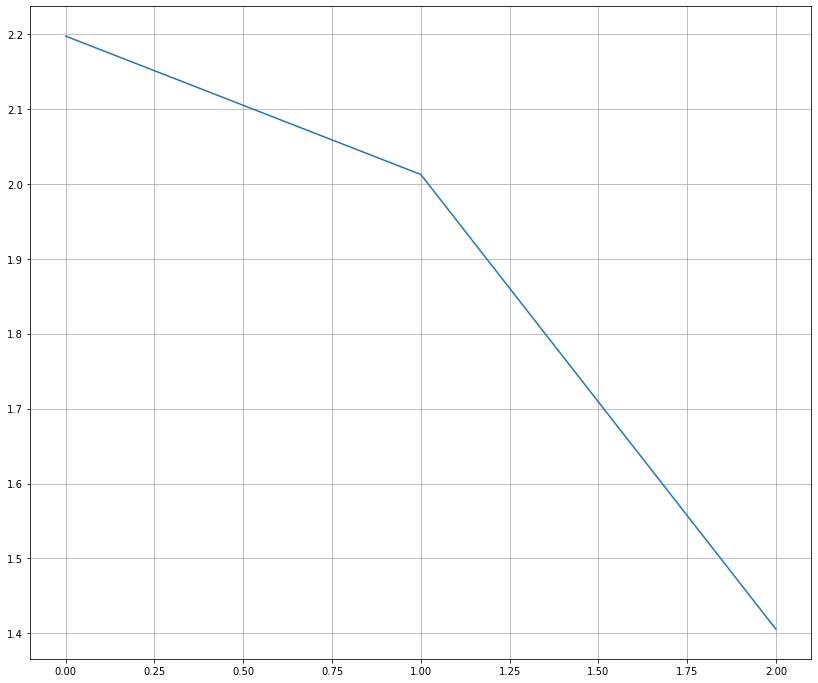

In [62]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), losses)
plt.grid()

In [63]:
losses = list()
preds = list()
acc_list = list()

# заметьте, что мы поменяли наш лоадер на валидационный
losses = []

for i in trange(epochs):
  count = 0
  for x, y in valid_loader:
      
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          optimizer.zero_grad()

          optimizer.step()
          losses.append(loss)
          optimizer.zero_grad()
          optimizer.step()
          losses.append(loss)
  print(f"epoch {i}, loss {loss}")

 33%|███▎      | 1/3 [01:17<02:34, 77.36s/it]

epoch 0, loss 1.4055880308151245


 67%|██████▋   | 2/3 [02:41<01:19, 79.53s/it]

epoch 1, loss 1.4055880308151245


KeyboardInterrupt: ignored